# Логистическая регрессия как структурная часть нейронной сети

В рамках данной лабораторной работы необходимо будет создать модель на основе логистической регрессии по распознаванию кошек на изображении.
Данная работа является пошаговым руководством по созданию классификатора на базе логистической регрессии в контексте построения моделей машинного обучения.

**Инструкции:**
- Запрещено использовать циклы (for/while) в коде, за исключением тех случаев, где это явно не прописано в условии задачи.

**В рамках данной лабораторной работы будут приобретены следующие навыки (знания):**
   - Принципы построения алгоритма машинного обучения, в частности:
    - инициализация параметров;
    - вычисление функции потерь и его градиента;
    - использовать алгоритм оптимизации (градиентный спуск).
   - Принципы сбора всех частей алгоритма в единую (главную) функцию в правильной последовательности

`Данный материал опирается и использует материалы курса Deep Learning от организации deeplearning.ai`
 
 Ссылка на основной курс (для желающих получить дополнительный сертификаты): https://www.coursera.org/specializations/deep-learning

## 1 - Пакеты/Библиотеки ##

Первоначально необходимо запустить ячейку ниже, чтобы импортировать все пакеты, которые вам понадобятся во время лабораторной работы.
- [numpy](www.numpy.org) является основным пакетом для научных вычислений в Python.
- [h5py](http://www.h5py.org) это общий пакет для взаимодействия с набором данных, которые хранятся в файле H5.
- [matplotlib](http://matplotlib.org) это пакет для отрисовки графиков в Python.
- [PIL](https://pillow.readthedocs.io/en/stable/) и [scipy](https://www.scipy.org/) используются здесь, чтобы проверить построенную модель с собственным (загруженным) изображением в конце лабораторной работы.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## 2 - Постановка задачи ##

Дан набор данных ("data.h5") содержащий:
    - обучающий набор `m_train` изображений размеченных как `cat` (`y=1`) или `non-cat` (`y=0`);
    - тестовый набор `m_test` изображений размеченных как `cat` (`y=1`) или `non-cat` (`y=0`);
    - каждое изображение имеет размер (`num_px`, `num_px`, `3`) где `3` это количество каналов (RGB). Таким образом, каждое изображение это квадрат, где (`height = num_px`) и (`width = num_px`).

Требуется построить прострой алгоритм, который сможет классифицировать объект на изображении (`cat` это или `non-cat`).

Для того чтобы познакомиться с набором данных, загрузите блок с кодом ниже.

In [3]:
# Загрузка данных
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [4]:
train_set_x_orig.shape

(209, 64, 64, 3)

Каждая строка в обучающем (`train_set_x_orig`) и тестовом (`test_set_x_orig`) массиве данных является изображением.
Следующий блок с кодом визуализирует изображение.
Попробуйте поменять индекс массива, чтобы посмотреть различные примеры изображений.

y = [1], Это 'cat' на изоражении.


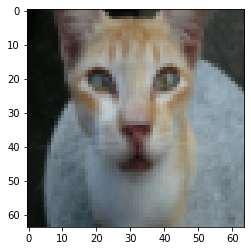

In [6]:
# Пример изображения
index = 11
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", Это '" 
       + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' на изоражении.")

Множество ошибок в глубоком обучении имеет причину, связанную с неверным использованием размеров матриц/векторов при выполнении операции с ними.

**Упражнение**

Найдите значения для:
    - `m_train` (количество обучающих примеров)
    - `m_test` (количество тестовых примеров)
    - `num_px` (`height = width` изображения из обучающего массива)
Напоминание: `train_set_x_orig` это numpy-array размером (`m_train`, `num_px`, `num_px`, `3`).
Например, для того, чтобы получить доступ к первой размерности `m_train` необходимо написать `train_set_x_orig.shape[0]`.

In [ ]:
### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 3 строки кода)
m_train = None
m_test = None
num_px = None
### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###

print ("Количество обучающих примеров: m_train = " + str(m_train))
print ("Количество тестовых примеров: m_test = " + str(m_test))
print ("Height/Width для каждого изображения: num_px = " + str(num_px))
print ("Каждое изображение имеет размер: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

**Ожидаемый результат для m_train, m_test и num_px**: 
<table style="width:20%">
  <tr>
    <td>m_train</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>m_test</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>num_px</td>
    <td> 64 </td> 
  </tr>
  
</table>


Для удобства можно преобразовать размер изображения (`num_px`, `num_px`, `3`) в массив numpy-array размером (num_px $*$ num_px $*$ 3, 1).
После этого обучающее (тестовое) изображение в виде numpy-array представляет собой flattened (вытянутое/сплющенное) изображение.

**Упражнение**

Необходимо изменить размеры обучающего и тестового набора данных таким образом,
чтобы из матрицы размером (`num_px`, `num_px`, `3`) получился вектор (num\_px $*$ num\_px $*$ 3, 1).

Если есть потребность сделать преобразование изображения (матрицы) X размером (a,b,c,d) в вектор X_flatten размером (b$*$c$*$d, a), то можно использовать: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T это операция транспонирования X
```

In [ ]:
# Измените размер обучающего и тестового множества примеров

### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
train_set_x_flatten = None
test_set_x_flatten = None
### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

**Ожидаемый результат**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

Для представления цветных изображений используется красный, зеленый и синий каналы (RGB),
которые представляют собой вектор из трех чисел (пикселей) в диапазоне от 0 до 255.

Один из общих и основных шагов в машинном обучении это центрирование и стандартизация датасета.
Это означает вычитание среднего из каждого элемента массива и затем деление на стандартное отклонение по всем элементам.
Но для датасета из изображений применяется немного другой метод, который заключается в делении каждого элемента на 255 (это максимальное значение пикселя).

<!-- Во время обучения модели вы будете умножать веса и добавлять смещения к некоторым начальным входам, чтобы наблюдать за активациями нейронов.
Затем для обучения модели требуется вычислить градиенты. Но для каждого объекта крайне важно иметь одинаковый диапазон, чтобы наши градиенты не "взрывались".
Вы увидите это более подробно позже в лекциях!-->

In [ ]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>
**Что нужно помнить:**

Общие шаги для предварительной обработки нового набора данных:
- Выяснить размеры и формы изображений для решаемой задачи (`m_train`, `m_test`, `num_px`, ...)
- Измените наборы данных таким образом, чтобы каждый пример представлял собой вектор размера (num_px \* num_px \* 3, 1)
- "Стандартизовать" данные

## 3 - Основной процесс построения обучающего алгоритма ##

Далее необходимо разработать простой алгоритм, умеющий различать изображения с `cat` от изображений `non-cat`.

Используемая модель: логистическая регрессия как структурная составляющая нейронной сети.
На следующем рисунке дано объяснение связи между логистической регрессией и нейронной сетью.

**Логистическая регрессия, как очень простая нейронная сеть!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Математическое объяснение алгоритма**:

Для одного примера $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Функция потерь вычисляется как сумма для всех обучающих примеров:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Ключевые шаги**:
В рамках данной лабораторной работы необходимо сделать следующие ключевые шаги: 
    - инициализация параметров модели;
    - подбор параметров модели, соответствующие минимуму функции потерь;
    - использование полученных параметров для предсказания (на тестовой выборке);
    - анализ результатов и выводы

## 4 - Строим по частям алгоритм ##

Главными шагами в построении простой нейронной сети является:
1. Определение структуры модели (например количество входных признаков).
2. Инициализация параметров модели.
3. Цикл:
    - вычисление текущих значений функции потерь (forward propagation)
    - вычисление текущих градиентов (backward propagation)
    - обновление параметров (gradient descent)

Достаточно часто отдельно готовятся три функции, соответствующие 3-м предыдущим шагам, а только затем создается обобщающая функция `model()`.

### 4.1 - Функции - помощники

**Упражнение** Используя основы Python, разработайте функцию `sigmoid()`.

Как вы видели на рисунке выше, вам необходимо вычислить $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$. Используйте np.exp().

In [ ]:
# ОЦЕНИВАЕМОЕ: sigmoid

def sigmoid(z):
    """
    Вычисление sigmoid от z

    Arguments:
    z -- скаляр или числовой массив любого размера

    Return:
    s -- sigmoid(z)
    """
    s = None
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 1 строка кода)
    
    
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    return s

In [ ]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

**Ожидаемый результат**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Инициализация параметров

**Упражнение** Инициализируйте параметры запустив ячейку ниже.
Необходимо инициализировать веса `w` как вектор нулей.
Если вы не знаете функции в numpy, которая это выполняет, то посмотрите как работает функция np.zeros() в документации Numpy.

In [ ]:
# ОЦЕНИВАЕМОЕ: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    Эта функция создает вектор нулей размером (dim, 1) для весов w и инициализирует b как 0.
    
    Argument:
    dim -- размер вектора весов w (или количество признаков, подаваемых на вход)
    
    Returns:
    w -- инициализированный вектор весов (weights) размеров (dim, 1)
    b -- инициализорованный скаляр (bias)
    """
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    w = None
    b = None
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

In [ ]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

**Ожидаемый результат**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

Для каждого входного изображения, w должно иметь размер (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Прямое (forward) и Обратное (backward) распространение 

Теперь, когда параметры инициализированы, можно выполнить шаги "forward" и "backward" распространения для подбора параметров.

**Упражнение** Реализовать функцию `propagate()` которая вычисляет функция потерь (cost function) и его градиент.

**Подсказка**:

Прямое распространение:
- Получаете X
- Вычисляете $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- Вычисляете функцию потерь: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Ниже написаны формулы, которые можно использовать для вычисления градиента:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [ ]:
# ОЦЕНИВАЕМОЕ: propagate

def propagate(w, b, X, Y):
    """
    Реализуйте функцию потерь и её градиент

    Arguments:
    w -- веса(weights), numpy массив размером (num_px * num_px * 3, 1)
    b -- смещение(bias), скаляр
    X -- данные размером (num_px * num_px * 3, кол-во примеров)
    Y -- вектор меток "label" (содержащий 0 "non-cat", 1 если "cat") размером (1, количество примеров)

    Return:
    cost -- значение функции потерь для логистической регрессии
    dw -- градиент для весов w, размер совпадает с размером вектора весов w
    db -- градиент для смещений b, размер совпадает с размером смещения b
    
    Подсказка:
    - Можно использовать функции: np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # прямое распространение
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    A = None # функция активации
    cost = None # функция потерь
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    # обратное распространение
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 2 строки кода)
    dw = None
    db = None
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

**Ожидаемый результат**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
        <td> [[ 0.99993216]
 [ 1.99980262]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.499935230625 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 6.000064773192205</td>
    </tr>

</table>

### Оптимизация
- У вас реализована инициализация параметров.
- Вы реализовали функцию, которая вычисляет функцию потерь и его градиент.
- В следующем упражнении необходимо реализовать градиентный спуск, который будет обновлять значения функции потерь и его градиентов.

**Упражнение:** Реализуйте функцию градиентного спуска. 
Цель состоит в том, чтобы обучить параметры $w$ и $b$ минимизируя функцию потерь $J$. Для параметра $\theta$, правилом обновления является $ \theta = \theta - \alpha \text{ } d\theta$, где $\alpha$ скорость обучения.

In [ ]:
# ОЦЕНИВАЕМОЕ: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Функция оптимизации w и b и запуск алгоритма градиентого спуска
    
    Arguments:
    w -- веса(weights), numpy массив размером (num_px * num_px * 3, 1)
    b -- смещение(bias), скаляр
    X -- данные размером (num_px * num_px * 3, number of examples)
    Y -- вектор меток "label" (содержащий 0 "non-cat", 1 если "cat") размером (1, количество примеров)
    num_iterations -- количество итерация обучения
    learning_rate -- скорость/длина шага по градиенту
    print_cost -- True печать каждые 100 шагов
    
    Returns:
    params -- словарь, содержащий веса w и смещения b
    grads  -- словарь, содержащий градиенты весов и смещений относительно функции стоимости
    costs  -- список значений функции потерь, рассчитанных во время оптимизации,
              будет использован для построения кривой обучения.
    
    Подсказка:
    Для реализации алгоритма градиентного спуска необходимо выполнить два шага:
        1) Рассчитать значение функции потерь и градиент для текущих параметров. Используйте propagate().
        2) Обновите параметры, используя правило градиентного спуска для w и b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        # Вычисление значения функции потерь и градиентов (≈ 1-4 строки кода)
        ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### 
        grads, cost = None
        ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
        
        # Запись производных
        dw = grads["dw"]
        db = grads["db"]
        
        # Правило обновления (≈ 2 строки кода)
        ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ###
        w = None
        b = None
        ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
        
        # Запись значения функции потерь
        if i % 100 == 0:
            costs.append(cost)
        
        # Печать каждые 100 обучающих примеров
        if print_cost and i % 100 == 0:
            print("Cost после итерации %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

**Ожидаемый результат**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.1124579 ], [ 0.23106775]] </td>
    </tr>
    <tr>
       <td> **b** </td>
       <td> 1.55930492484 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.90158428], [ 1.76250842]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.430462071679 </td>
    </tr>
</table>

**Упражнение** Предыдущая функция выведет подобранные w и b. Вы можете использовать w и b, чтобы предсказать метки для набора данных X. Реализуйте функцию `predict()`. Есть два шага для вычисления прогнозов:

1. Вычислите $\hat{Y} = A = \sigma(w^T X + b)$

2. Конвертировать записи в 0 (если функция активации <= 0.5) или 1 (если функция активации > 0.5), сохранять прогнозы в векторе `Y_prediction`. Если вы хотите, вы можете использовать `if`/`else` выражение в `for` цикле (хотя есть также способ векторизации). 

In [ ]:
# ОЦЕНИВАЕМОЕ: predict

def predict(w, b, X):
    '''
    Предсказание параметров, будет ли метка 0 или 1, используя обученные параметры логистической регрессии (w, b)
    
    Arguments:
    w -- веса(weights), numpy массив размером (num_px * num_px * 3, 1)
    b -- смещение(bias), скаляр
    X -- данные размером (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- numpy массив (вектор) содержащий предсказания (0/1) для примеров в матрице X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Вычислить вектор «A», предсказывающий вероятности присутствия cat на снимке
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 1 строка кода)
    A = None
    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    for i in range(A.shape[1]):
        
        # Конвертировать вероятности A[0,i] к реальным прогнозам p[0,i]
        ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ### (≈ 4 строки кода)

        
        ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
print ("предсказания = " + str(predict(w, b, X)))

**Ожидаемый результат**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.]]
         </td>  
   </tr>

</table>


<font color='blue'>

**Что необходимо помнить:**

Вы реализовали несколько функций, которые выполняют:

- инициализацию (w,b)
- итеративную оптимизацию функции потерь для обучения параметров (w,b):
    - вычисление функции потерь и его градиентов 
    - обновление параметров с использованием градиентного спуска
- предсказание метки для данного набора примеров на основе обученных (w,b).

## 5 - Объединить все функции в модель ##

Теперь вы увидите, как структурируется общая модель, собрав вместе все строительные блоки (функции, реализованные в предыдущих частях) в правильном порядке.

**Упражнение** Реализуйте функцию модели. Используйте следующие обозначения:
    - `Y_prediction` для прогнозов на тестовом наборе
    - `Y_prediction_train` для прогнозов на обучающем наборе
    - `w`, `costs`, `grads` для выходов функции оптимизации `optimize()`

In [ ]:
# ОЦЕНИВАЕМОЕ: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Создает модель логистической регрессии, вызывая функции, которые вы реализовали ранее 
    
    Arguments:
    X_train -- обучающий набор, представленный numpy массивом размером (num_px * num_px * 3, m_train)
    Y_train -- метки для обучения преставлены numpy массивом (вектором) размером (1, m_train)
    X_test -- тестовый набор, представленный numpy массивом размером  (num_px * num_px * 3, m_test)
    Y_test -- метки для тестирования преставлены numpy массивом (вектором) размером (1, m_test)
    num_iterations -- гиперпараметр, представляющий количество интераций оптимизации параметров
    learning_rate -- гиперпараметр, представляющий скорость обучения/длину градиентного шага для функции optimize()
    print_cost -- печать каждые 100 шагов
    
    Returns:
    d -- словарь, содержащий информацию о модели.
    """
    
    ### НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ###
    
    # Инициализируйте параметры (≈ 1 строка кода)
    w, b = None

    # Градиентный спуск (≈ 1 строка кода)
    parameters, grads, costs = None
    
    # Запись производных в словарь "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Предсказание test/train для набора примеров (≈ 2 строки кода)
    Y_prediction_test = None
    Y_prediction_train = None

    ### ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ###

    # Печать точности (accuracy) неверных предсказаний на train/test наборах
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Запустите следующую ячейку, чтобы обучить вашу модель.

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, 
          num_iterations = 2000, learning_rate = 0.005, print_cost = True)

**Ожидаемый результат**: 

<table style="width:40%">   
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 

**Комментарий**: Точность на обучающей выборке близка к 100%. Ошибка на тестовой выборке составляет 70%. Это на самом деле неплохо для этой модели, учитывая небольшой набор данных, который мы использовали, и то, что логистическая регрессия достаточно простая модель.

Также вы можете наблюдать эффект переобучения (overfitting). 

Используя приведенный ниже код (и изменяя переменную `index`) вы можете посмотреть прогнозы на рисунках тестового набора.

In [ ]:
index = 15
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", ваше предсказание, что это класс " + 
       classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  " на изображении.")

Давайте также построим функцию стоимости и градиенты.

In [ ]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('Итерации (деленное на 100)')
plt.title("Длина градиентного шага =" + str(d["learning_rate"]))
plt.show()

**Интерпретация**:

Вы можете увидеть снижение стоимости. Это показывает, что параметры обучаются. Однако вы видите, что можете тренировать модель еще дольше на обучающей выборке. Попробуйте увеличить количество итераций в ячейке выше, и перезапустите ячейки. Вы можете видеть, что точность тренировочного набора повышается, но точность тестового набора снижается. Это называется переобучением (overfitting).

## 6 - Дальнейший анализ ##

Давайте проанализируем работу модели и рассмотрим возможные варианты для скорости обучения $\alpha$. 

#### Выбор скорости обучения ####

**Напоминание**:
Для того, чтобы Gradient Descent работал, вы должны грамотно выбирать скорость обучения. Скорость обучения $\alpha$ определяет, насколько быстро обновляются параметры. Если скорость обучения слишком велика, мы можем «перешагнуть» оптимальное значение. Точно так же, если она слишком мал, нам потребуется слишком много итераций, чтобы сходиться к лучшим значениям. Вот почему важно использовать хорошо настроенную скорость обучения.

Давайте сравним кривую обучения нашей модели с несколькими вариантами обучения. Запустите ячейку ниже. Это должно занять около 1 минуты. Не стесняйтесь также попробовать значения, отличные от трех, которые инициализированные в примере для переменной `learning_rates`.

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("Скорость обучения: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Интерпретация**: 
- Разные значения скорости обучения дают разные значения функции потерь и, следовательно, разные результаты прогнозов.
- Если скорость обучения значительно большое (0.01), значение функции потерь может колебаться, то вверх, то вниз. Значение функции потерь даже может расходиться.
- Более маленькое значение функции потерь не означает лучшую модель. Вы должны проверить, возможно ли переобучение. Это происходит, когда точность на обучающей выборке намного выше, чем точность на тестовой.

## 7 - Тестирование с вашими изображениями ##

Вы можете использовать собственные изображения для тестирования разработанной модели. Что необходимо сделать:
    1. Загрузите своё изображение в директорию /image/;
    2. В коде ниже подставьте наименование изображения, соответствующее вашему;
    3. Запустите алгоритм ниже (1 = `cat`, 0 = `non-cat`).

In [ ]:
## НАЧАЛО ВАШЕГО КОД ЗДЕСЬ ## (вставьте своё изображение) 
my_image = "my_image.jpg"   # измените на имя своего изображения
## ОКОНЧАНИЕ ВАШЕГО КОД ЗДЕСЬ ##

# Предобработка изображения и передача его в алгоритм.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", модель предсказала \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")


**Что необходимо запомнить:**

1. Предварительная обработка набора данных необходима.
2. Реализации каждой функции в отдельности: `initialize()`, `propagate()`, `optimize()`. Затем построение модели `model()`.
3. Настройка скорости обучения (которая является гиперпараметром - "hyperparameter") являтся важным аспектом обучения, так как она может привести к различным результатам.

Возможности для экспериментов:
  - Изменение скорости обучения и количество итераций
  - Попробуйте разные методы инициализации и сравните результаты.
  - Проверьте другие предварительные обработки (центрируйте данные или разделите каждую строку по ее стандартному отклонению)

Используемый материал:
- Курс Deep Learning; https://www.coursera.org/specializations/deep-learning
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c